<div style="text-align: right">Ventilator distribution Challenge</div>
<div style="text-align: right">Dino Konstantopoulos, The MITRE Corporation 2020</div>

# Ventilator Sharing

In this python notebook we introduce a framework for fair distribution of US stock ventilators across hospitals.One that is not along state or political lines, but rather according to fair demand for ventilators. The goal is to enable multi-state collaboration on the sharing and deployment of US ventilator stock without preferential regional treatment. We use the existing national supply of available respirators, with knowledge of average period of intubation and minimum transit/cleaning/redeployment per unit. We ferry that supply nationally with air cargo, and then on regionally with trucks.

The current ventilator distribution scheme is an every-hospital-system-for-themselves approach, in which some hospitals will "*take them all*" if they can afford them, while others will lack the capital to make such large purchases in advance and therefore will be reliant on FEMA, which will be forced to ration scarce, lifesaving equipment. Cash-strapped hospitals serving poorer populations will soon be put in even greater jeopardy.

The solution advanced in this notebook is based on the [bike-sharing model](https://towardsdatascience.com/applied-exploratory-data-analysis-the-power-of-visualization-bike-sharing-python-c5b2645c3595) in select US cities: Locations are identified based on pre-defined metrics (for bike sharing, these could be weather data for example), and then bikes are made available to the public in a maximal-use logisitical scheme. There is no "*preferred*" site, all bikes are shared across all communities simply according to demand. Ventilators need to depend on patient-based demand, at hospitals.

What we have to evaluate is how to optimally emplace ventilator distribution points so that US stock ventilators are optimally leveraged across all US hospitals, fairly.

The first things we need is a map of hospital situations across the US; infection or intubation data. Hospitals can call FEMA and provide current usage and desired usage for ventilators (infection counts may also be provided as a proportional alternative). These rates can then be plotted on a US map in order to build a scatter map of ventilator demand. 

### National level clusters
At a first level of decomposition, the national level, FEMA charters cargo planes and moves the ventilators to optimal national locations.

### Regional level clusters
As the cargo planes with stock ventilators land in designated airports, trucks subdivide the supply and move ventilators to regional distribution locations, which could be a warehouse or a rapidly erected distribution center. The ventilators could also remain in the trucks. Ambulances from each hospital can then drive to the regional distribution center to pick up their share of ventilators.

So what we need to figure out is given a demand plot, how do we optimally assign the supply.

We will use modern data science, specifically Bayesian estimation, to assign the supply based on demand. We start with a prototype in one dimension in order to understand the theory, and then we move to two dimensions and real physical maps.

# Creating data

Let's start by creating some data to model three different focal points of infection along a line. The data may represent current ventilator usage, or also number of infected patients across a long highway. 

In [93]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.mixture import GaussianMixture

from matplotlib.colors import LogNorm

import pandas as pd
import scipy as spy

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [94]:
random_state = np.random.RandomState(seed=1)

We use three normal distributions at three different loci, and reshape them to 2D with `reshape{-1,1)` in order to fit the data to a probabilistic library we're going to leverage. But we first plot the data and its histogram.

That data consists of a simple concatenation of three normal distributions with different centers and standard deviations, and a different number of data points.

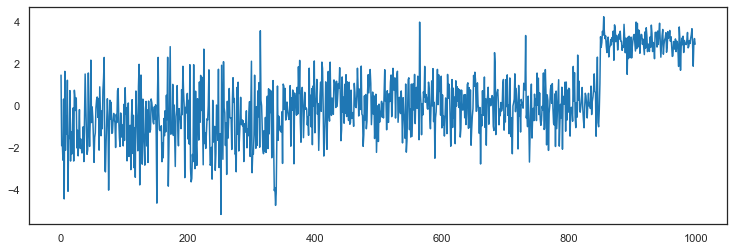

In [95]:
X = np.concatenate([random_state.normal(-1, 1.5, 350),
                    random_state.normal(0, 1, 500),
                    random_state.normal(3, 0.5, 150)]).reshape(-1, 1)
plt.plot(X)

The data can represent a superposition of three sites of infection. You can see that one site has greater numbers (I don't know what the negative numbers may represent but let's jost leave the data as is for now) representing either a higher usage of ventilators or just more infections. If not from the data, we can definitely tell from the histogram:

(array([0.00319011, 0.00638022, 0.00319011, 0.01276044, 0.01276044,
        0.01276044, 0.02871099, 0.05104175, 0.04785164, 0.09251317,
        0.13079449, 0.12760438, 0.16588569, 0.21373733, 0.25839887,
        0.28072963, 0.29029996, 0.23925821, 0.22011755, 0.18821646,
        0.12122416, 0.09570328, 0.06380219, 0.06061208, 0.06061208,
        0.11803405, 0.13717471, 0.10527361, 0.02552088, 0.01595055]),
 array([-5.1896275 , -4.87615863, -4.56268977, -4.2492209 , -3.93575204,
        -3.62228317, -3.3088143 , -2.99534544, -2.68187657, -2.3684077 ,
        -2.05493884, -1.74146997, -1.42800111, -1.11453224, -0.80106337,
        -0.48759451, -0.17412564,  0.13934322,  0.45281209,  0.76628096,
         1.07974982,  1.39321869,  1.70668756,  2.02015642,  2.33362529,
         2.64709415,  2.96056302,  3.27403189,  3.58750075,  3.90096962,
         4.21443848]),
 <a list of 1 Patch objects>)

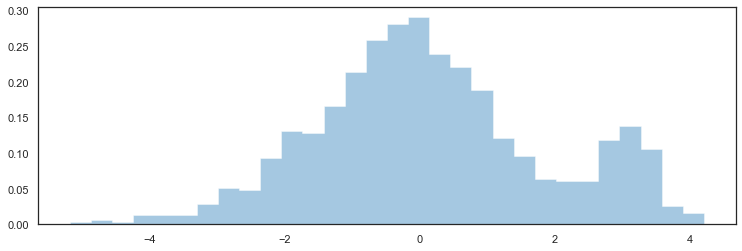

In [96]:
plt.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)

Actually the histogram looks like there are *two* sites of infection.

We are ready to try to find the sites of infection. Just by looking at the histogram, we are going to assume two sites of infection.

We are going to build a **Gaussian Mixture** with 2 gaussians, which is a composite dataset made out of two gaussians with different means and standard deviations. Wikipedia defines a [mixture model](https://en.wikipedia.org/wiki/Mixture_model) as a probabilistic model for representing the presence of subpopulations within an overall population, without requiring that an observed data set should identify the sub-population to which an individual observation belongs. Formally a mixture model corresponds to the mixture distribution that represents the probability distribution of observations in the overall population. 

We use the probabilistic python library `scikit-learn` to create a mixture model with just one line of code (ok, two):

In [97]:
mixm = GaussianMixture(n_components=2, random_state=1, verbose=1)
mixm.fit(X)

Initialization 0
Initialization converged: True


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=1, reg_covar=1e-06, tol=0.001, verbose=1,
                verbose_interval=10, warm_start=False, weights_init=None)

Let's plot our Gaussian mixture as a line plot on top of the data histogram. We will use `scikit-learn`'s `.score_samples()` API to produce data from the model to see how it fits with our generated infection data.

It turns our that the `score_samples` API that allows us to produce data from the model yields actually the `log`arithm of the data (log is the math function that does the best **plastic surgery** to data so that it looks normal, or gaussian-like). That means that when we generate simulate data, we have to take the exponential of the data to superimpose on top of our histogram above.

(array([0.00319011, 0.00638022, 0.00319011, 0.01276044, 0.01276044,
        0.01276044, 0.02871099, 0.05104175, 0.04785164, 0.09251317,
        0.13079449, 0.12760438, 0.16588569, 0.21373733, 0.25839887,
        0.28072963, 0.29029996, 0.23925821, 0.22011755, 0.18821646,
        0.12122416, 0.09570328, 0.06380219, 0.06061208, 0.06061208,
        0.11803405, 0.13717471, 0.10527361, 0.02552088, 0.01595055]),
 array([-5.1896275 , -4.87615863, -4.56268977, -4.2492209 , -3.93575204,
        -3.62228317, -3.3088143 , -2.99534544, -2.68187657, -2.3684077 ,
        -2.05493884, -1.74146997, -1.42800111, -1.11453224, -0.80106337,
        -0.48759451, -0.17412564,  0.13934322,  0.45281209,  0.76628096,
         1.07974982,  1.39321869,  1.70668756,  2.02015642,  2.33362529,
         2.64709415,  2.96056302,  3.27403189,  3.58750075,  3.90096962,
         4.21443848]),
 <a list of 1 Patch objects>)

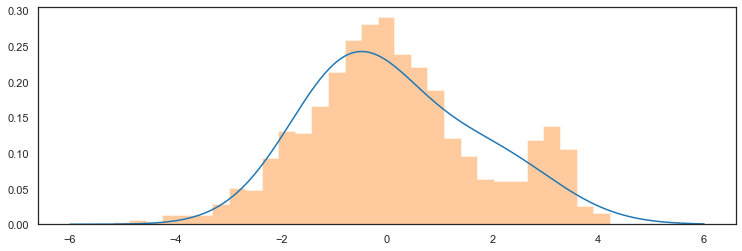

In [98]:
x = np.linspace(-6, 6, 1000)
logprob = mixm.score_samples(x.reshape(-1, 1))
pdf = np.exp(logprob)
plt.plot(x, pdf)
plt.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)

It does not look that bad, but it also does not look great as we severely underestimate the size of the second peak (site of the 2nd infection locus).

Let's now plot the two gaussians that gave us the mixture above.

(array([0.00319011, 0.00638022, 0.00319011, 0.01276044, 0.01276044,
        0.01276044, 0.02871099, 0.05104175, 0.04785164, 0.09251317,
        0.13079449, 0.12760438, 0.16588569, 0.21373733, 0.25839887,
        0.28072963, 0.29029996, 0.23925821, 0.22011755, 0.18821646,
        0.12122416, 0.09570328, 0.06380219, 0.06061208, 0.06061208,
        0.11803405, 0.13717471, 0.10527361, 0.02552088, 0.01595055]),
 array([-5.1896275 , -4.87615863, -4.56268977, -4.2492209 , -3.93575204,
        -3.62228317, -3.3088143 , -2.99534544, -2.68187657, -2.3684077 ,
        -2.05493884, -1.74146997, -1.42800111, -1.11453224, -0.80106337,
        -0.48759451, -0.17412564,  0.13934322,  0.45281209,  0.76628096,
         1.07974982,  1.39321869,  1.70668756,  2.02015642,  2.33362529,
         2.64709415,  2.96056302,  3.27403189,  3.58750075,  3.90096962,
         4.21443848]),
 <a list of 1 Patch objects>)

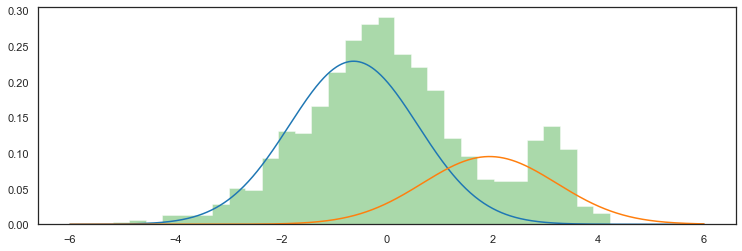

In [99]:
responsibilities = mixm.predict_proba(x.reshape(-1, 1))
pdf_individual = responsibilities * pdf[:, np.newaxis]
plt.plot(x, pdf_individual)
plt.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)

Looking at this, it is apparent that there has to be an *extra* cluster to the *left* (taking over responsibility for datapoints to the left) because the two peaks seem to be offset from the real peaks! So, as good data scientists, we wiil try another mixture model that this time is generated by ***3*** offset gaussians!

In [100]:
mixm = GaussianMixture(n_components=3, random_state=1, verbose=1)
mixm.fit(X)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=1, reg_covar=1e-06, tol=0.001, verbose=1,
                verbose_interval=10, warm_start=False, weights_init=None)

and we plot:

(array([0.00319011, 0.00638022, 0.00319011, 0.01276044, 0.01276044,
        0.01276044, 0.02871099, 0.05104175, 0.04785164, 0.09251317,
        0.13079449, 0.12760438, 0.16588569, 0.21373733, 0.25839887,
        0.28072963, 0.29029996, 0.23925821, 0.22011755, 0.18821646,
        0.12122416, 0.09570328, 0.06380219, 0.06061208, 0.06061208,
        0.11803405, 0.13717471, 0.10527361, 0.02552088, 0.01595055]),
 array([-5.1896275 , -4.87615863, -4.56268977, -4.2492209 , -3.93575204,
        -3.62228317, -3.3088143 , -2.99534544, -2.68187657, -2.3684077 ,
        -2.05493884, -1.74146997, -1.42800111, -1.11453224, -0.80106337,
        -0.48759451, -0.17412564,  0.13934322,  0.45281209,  0.76628096,
         1.07974982,  1.39321869,  1.70668756,  2.02015642,  2.33362529,
         2.64709415,  2.96056302,  3.27403189,  3.58750075,  3.90096962,
         4.21443848]),
 <a list of 1 Patch objects>)

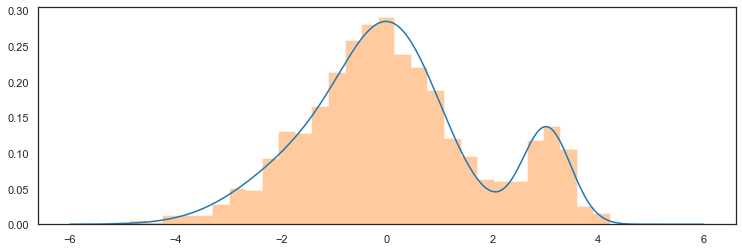

In [101]:
x = np.linspace(-6, 6, 1000)
logprob = mixm.score_samples(x.reshape(-1, 1))
pdf = np.exp(logprob)
plt.plot(x, pdf)
plt.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)

And now we see we have correctly captured the data as a mixture of 3 different infection loci. Let's plot these:

(array([0.00319011, 0.00638022, 0.00319011, 0.01276044, 0.01276044,
        0.01276044, 0.02871099, 0.05104175, 0.04785164, 0.09251317,
        0.13079449, 0.12760438, 0.16588569, 0.21373733, 0.25839887,
        0.28072963, 0.29029996, 0.23925821, 0.22011755, 0.18821646,
        0.12122416, 0.09570328, 0.06380219, 0.06061208, 0.06061208,
        0.11803405, 0.13717471, 0.10527361, 0.02552088, 0.01595055]),
 array([-5.1896275 , -4.87615863, -4.56268977, -4.2492209 , -3.93575204,
        -3.62228317, -3.3088143 , -2.99534544, -2.68187657, -2.3684077 ,
        -2.05493884, -1.74146997, -1.42800111, -1.11453224, -0.80106337,
        -0.48759451, -0.17412564,  0.13934322,  0.45281209,  0.76628096,
         1.07974982,  1.39321869,  1.70668756,  2.02015642,  2.33362529,
         2.64709415,  2.96056302,  3.27403189,  3.58750075,  3.90096962,
         4.21443848]),
 <a list of 1 Patch objects>)

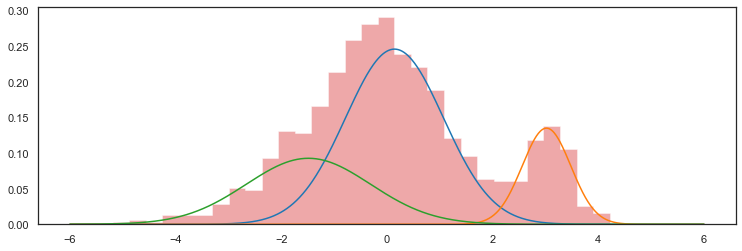

In [102]:
responsibilities = mixm.predict_proba(x.reshape(-1, 1))
pdf_individual = responsibilities * pdf[:, np.newaxis]
plt.plot(x, pdf_individual)
plt.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)

So it is clear we have are 3 different infection loci, with the middle one representing a large concetrated population of infected (or intubated) idividuals, the one to the left a smaller cluster with a wider area of provenance, while the one to the right is also smaller but even more concentrated.

It seems logical to assume that optimal placement of ventilator supply would be at the center locus of each infection, in order to fairly distribute ventilator supply across hospitals in the region. 

Of course, we cheated a bit here because we were close to the correct guess (2 instead of 3), then we bumped up by one. What if there are really, say, 10 clusters of infection, or 10 hospitals with the biggest demand for intubation. How can we determine the optimal number?

Well, no silver bullet here. We have to try all numbers:

In [103]:
# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

Now we compute some statistical criteria to help us pick the best possible model.

The two most popular information criteria for statistical models are [Akaike's Information criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) (**AIC**), discovered by the statistician [Hirotugu Akaike](https://en.wikipedia.org/wiki/Hirotugu_Akaike), and the [Bayesian information criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) (**BIC**), discovered by Gideon E. Schwarz, both of which are included in `scikit-learn`!

When a statistical model is used to represent a process that generated the data, some information will be lost by using the model to represent the data. AIC estimates the relative amount of information lost by a given model: the less information a model loses, the higher the quality of that model.

Gideon uses some linear algebra in his reasoning, so I won't give you more details. Linear Algebra is next on our topics to discover! If you want to know more about it, it's [here](https://www.andrew.cmu.edu/user/kk3n/simplicity/schwarzbic.pdf).

In [104]:
# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

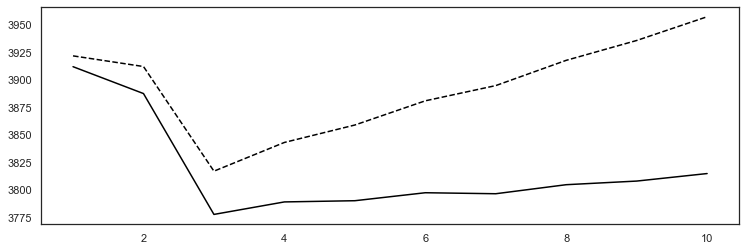

In [105]:
plt.plot(N, AIC, '-k', label='AIC')
plt.plot(N, BIC, '--k', label='BIC')

And we can see immediately that the best possible model is the mixture model consisting of ***3*** gaussian clusters.

So, if we were to delineate areas of responsibility at a national or regional level, so that we can send the cargo planes and then eventually the trucks with the ventilators, in a way that is completley dependent just on fair demand of ventilators rather than state lines, how do we do this?

In other words, what are the areas of responsibility of each cluster?

Text(0, 0.5, '$p({\\rm class}|x)$')

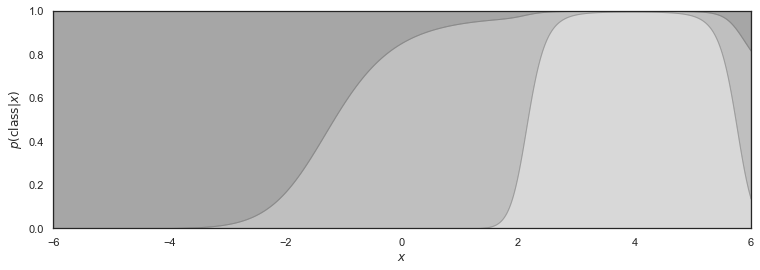

In [106]:
p = responsibilities
p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T

plt.fill_between(x, 0, p[0], color='gray', alpha=0.3)
plt.fill_between(x, p[0], p[1], color='gray', alpha=0.5)
plt.fill_between(x, p[1], 1, color='gray', alpha=0.7)
plt.xlim(-6, 6)
plt.ylim(0, 1)
plt.xlabel('$x$')
plt.ylabel(r'$p({\rm class}|x)$')

And now we have a picture of where to emplace fair distribution spots for ventilators: At x = 4 for the righnost-area of responsibility. Any hospital in the light gray area will send its ambulances to $x = 4$ to receive available ventilators. Any hospital in the medium gray area at $x = 0$, and any hospital in the dark greay area, at $x = -4$.

Now that we know how the framework works, let's move on to 2D and real maps.

# Moving to 2 dimensions

The statistical theory that underlies our model above has a name. It's called [expectation–maximization](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) (EM). It is an iterative method to find maximum likelihood or maximum a posteriori (MAP) estimates of parameters in statistical models, where the model depends on unobserved latent variables. Our latent variables ree the points of infection, where the most intubations will be required. Where we should prioritize US stock distribution points.

The EM algorithm's iteration alternates between performing an expectation (E) step, which creates a function for the expectation of the log-likelihood evaluated using the current estimate for the parameters, and a maximization (M) step, which computes parameters maximizing the expected log-likelihood found on the E step. These parameter-estimates are then used to determine the distribution of the latent variables in the next E step.

With the introduction of modern Bayesian probabilsitic libraries like `PyMC3` (scikit-learn was also retrofitted with Bayesian methods), better algorithms are now available. For example, [Variational Inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods) is now used in complex statistical models consisting of observed variables ("*data*") as well as unknown parameters and latent variables, with various sorts of relationships among the three types of random variable. So we could also add constraints, which in our case may represent airport locations or exiting regional distribution centers in order to find best gaussian fits that also take pre-existing distribution centers into account. 

So now that we're in 2D, instead of gaussians we'll be plotting ellipsoids that will represent the areas of responsibility (AoR) for distribution centers. And we'll fit these AoR with respect to existing demand, which can be either number of intubations, or number os infections. We'll do it two ways, both with EM, as well with Variational Inference which ahs the advantage of giving us the optimal *number of ellipsoids* to fit the data, as well.

## Creating data

We now create artificial data that represents infections or number of intubations across hospitals. This could either be *across the nation*, or *regionally*. The idea is that we first decompose US into severely distressed regions potentially involving many states, and then once the stock ventilators are flown into respective airports, thy stock is further subdivided into substocks and trucked to regional distribution centers.

So we start with 5 clusters of different shapes: 3 round clusters, and two oblong clusters as infection/intubation numbers follow population models which can either be isotropic around a big city, or oblong, for example along Long Island, NY.

We mutiply multivariate (2D) normal distributions with a spatial correlation matrix to create oblong concentrations, and we concatenate these with more isotropic concentrations. We offset the centers of these concentrations by translation of a simple numpy array: 

In [109]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])

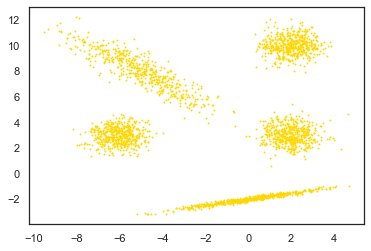

In [110]:
# Number of samples per component
n_samples = 500

# Generate 5 randomly placed and shaped ellipsoids, representing infections/intubations
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
D = np.array([[0., 0.7], [-1.7, 1.4]])
Y = np.r_[np.dot(np.random.randn(n_samples, 2), C) + np.array([0, -2]),
          np.dot(np.random.randn(n_samples, 2), D) + np.array([-5, 8]),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3]),
         .7 * np.random.randn(n_samples, 2) + np.array([2, 3]),
         .7 * np.random.randn(n_samples, 2) + np.array([2, 10])]
plt.scatter(Y[:, 0], Y[:, 1], .8, color='gold')

We're going to use the plotting function below to plot the gaussian mixtures:

In [77]:
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-10., 5.)
    plt.ylim(-5., 15.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

Let's see what it means to supply all 5 areas with a single distribution center: We fit a gaussian micture using a single ellipsoid representing a single distribution point closest to the center of the ellpsoid.

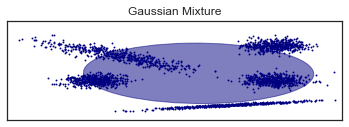

In [111]:
# Fit a Gaussian mixture with EM using one component
gmm = mixture.GaussianMixture(n_components=1, covariance_type='full').fit(Y)
plot_results(Y, gmm.predict(Y), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

How about 2 distribution centers?

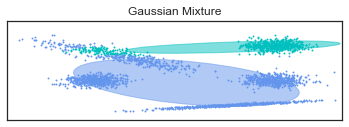

In [113]:
# Fit a Gaussian mixture with EM using two components
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(Y)
plot_results(Y, gmm.predict(Y), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

We can clearly see the AoR of each distribution center, and were to optimally emplace the distribution center: As close to the center of the ellipsoid.

How about 3 components?

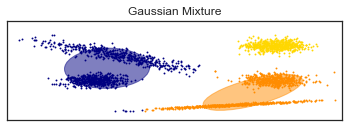

In [114]:
# Fit a Gaussian mixture with EM using three components
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full').fit(Y)
plot_results(Y, gmm.predict(Y), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

How about 4 components?

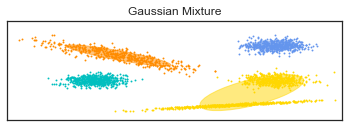

In [115]:
# Fit a Gaussian mixture with EM using four components
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full').fit(Y)
plot_results(Y, gmm.predict(Y), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

How about 5 components?

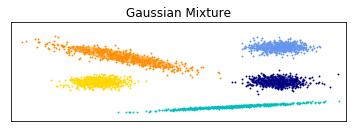

In [82]:
# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(Y)
plot_results(Y, gmm.predict(Y), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

And what if we have the opportunity of using 9 trucks to get as close to the hospitals as possible?

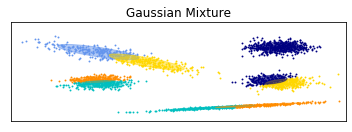

In [91]:
# Fit a Gaussian mixture with EM using nine components
gmm = mixture.GaussianMixture(n_components=9, covariance_type='full').fit(Y)
plot_results(Y, gmm.predict(Y), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

So we see that given an available fleet of cargo planes or regional trucks, we can get as close to the hospitals that actually need the ventilators.

With more advanced Variational Inference, we can also set constraints on distribution locations (i.e. along highways), or get the optimal number of distribution centers without any guesswork. Here we set the number of clustgers arbitrarily large, and we see that variational inference uncovers the correct number of clusters:

d:\Anaconda3.5.1\lib\site-packages\sklearn\mixture\base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


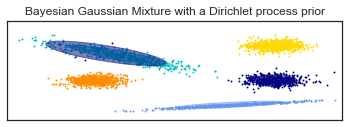

In [117]:
# Fit a Bayesian Gaussian mixture using ten components
dpgmm = mixture.BayesianGaussianMixture(n_components=10, covariance_type='full').fit(Y)
plot_results(Y, dpgmm.predict(Y), dpgmm.means_, dpgmm.covariances_, 0,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')

We see that the correct distribution locations (ellipsoid centers) can be precisely estimated.

# Conclusion

As cargo planes with stock ventilators land in designated airports, trucks further subdivide the supply and move ventilators to regional distribution locations, which could be a warehouse or a rapidly erected distribution center. The ventilators could also remain in the trucks. Ambulances from each hospital can then drive to the regional distribution center to pick up their share of ventilators, prioritized by their number of patients.

Once optimal locations *based on fair existing demand* are located, we could enter into partnership with private distribution centers, for example owned by Amazon or Federal Express, or UPS, and ship the ventilators to those locations. If we do end up working with pre-existing locations, those would be additional constraints on the model to place the individual gaussians at those locations. The gaussian mixture would then tell us how many ventilators to ship to each location.

Ambulances from hospitals assigned to each distribution center can pick up and then drop-off ventilators back to the distribution center. Hospitals can be assigned ventilators by distribution center using the same methodology, based purely on demand. Each hospital is assigned a quota based on a more refined hyper-local mixture model, which varies in time as the model tracks infections. If other hospitals at other locations see a much faster growing demand for ventilators, their quota increases, and the ventilators follow a reverse path back to the airports to be shipped to the correct location. This is the same model as bike shares. Intubator cleaning/transit time is a secondary consideration to where it needs to get shipped to in order to track demand. Gaussian mixture models are as democratic as possible!

## References

- [Applied Exploratory Data Analysis, Bike-Sharing, Medium](https://towardsdatascience.com/applied-exploratory-data-analysis-the-power-of-visualization-bike-sharing-python-c5b2645c3595)